# Hyperskill java dataset analysis

## Settings

In [1]:
import pandas as pd
import numpy as np

from typing import List, Dict
import string

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_theme(style='whitegrid', font_scale=1.25)

In [3]:
difficulty = ['easy', 'medium', 'hard']
difficulty_palette=dict(easy=(0.98, 0.73, 0.62), medium=(0.98, 0.41, 0.28), hard=(0.79, 0.09, 0.11))
complexity = ['shallow', 'middle', 'deep']
complexity_palette=dict(shallow=(0.77, 0.85, 0.93), middle=(0.41, 0.68, 0.83), deep=(0.12, 0.44, 0.70))
level = ['low', 'avg', 'high']
level_palette=dict(low=(0.77, 0.91, 0.75), avg=(0.45, 0.76, 0.46), high=(0.13, 0.54, 0.26))
client = ['idea', 'web']
client_palette=dict(idea=(0.52, 0.18, 0.44), web=(0.44, 0.49, 0.69))
template = [True, False]
template_palette={True: (0.79, 0.09, 0.11), False: (0.0, 0.0, 0.0)}

easy -> medium -> hard


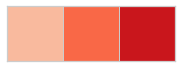

shallow -> middle -> deep


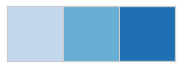

low -> avg -> high


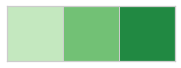

idea -> web


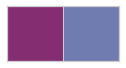

In [4]:
print(' -> '.join(difficulty))
sns.palplot(difficulty_palette.values())
plt.show()

print(' -> '.join(complexity))
sns.palplot(complexity_palette.values())
plt.show()

print(' -> '.join(level))
sns.palplot(level_palette.values())
plt.show()

print(' -> '.join(client))
sns.palplot(client_palette.values())
plt.show()

In [5]:
def merge_dfs(df_left: pd.DataFrame, df_right: pd.DataFrame, left_on: str, right_on: str) -> pd.DataFrame:
    df_merged = pd.merge(df_left, df_right, left_on=left_on, right_on=right_on, suffixes=('', '_extra'))
    df_merged.drop(df_merged.filter(regex='_extra$').columns.tolist(), axis=1, inplace=True)
    return df_merged

### Set path to following csv files (or use preset default)

In [6]:
users_file_path = '../data/java/users/users.csv'
steps_file_path = '../data/java/client/steps.csv'
topics_file_path = '../data/java/client/topics.csv'

submissions_file_path = '../data/java/result_submissions_java11.csv'
submissions_stats_file_path = '../data/java/result_submissions_stats_java11.csv'

raw_issues_stats_file_path = '../data/java/result_submissions_issues_stats_java11.csv'
raw_issues_change_stats_file_path = '../data/java/result_submissions_issues_change_stats_java11.csv'
qodana_issues_stats_file_path = '../data/java/qodana_issues_stats.csv'
raw_issues_classes_file_path = '../data/java/raw_issues.csv'
qodana_issues_classes_file_path = '../data/java/qodana_issues.csv'


### Load datasets

In [7]:
df_submissions = pd.read_csv(submissions_file_path)

FileNotFoundError: [Errno 2] No such file or directory: '../data/java/result_submissions_java11.csv'

In [ ]:
df_steps = pd.read_csv(steps_file_path)

### Filter submissions

In [ ]:
MAX_TOTAL_ATTEMPTS = 5

In [ ]:
df_last = df_submissions[df_submissions['attempt'] == df_submissions['total_attempts']][['id', 'user_id', 'step_id', 'client', 'attempt', 'total_attempts', 'group']]

d = df_last[df_last['total_attempts'] > MAX_TOTAL_ATTEMPTS].shape[0]
s = df_last.shape[0]
p = format(d / s * 100, '.2f')
print(f'Filtering {d}/{s} series with <{MAX_TOTAL_ATTEMPTS} attempts ~ {p}%')

In [ ]:
df_template = merge_dfs(df_submissions, df_steps, left_on='step_id', right_on='id')

d = df_template[df_template['template'] == True].shape[0]
s = df_submissions.shape[0]
p = format(d / s * 100, '.2f')
print(f'Filtering {d}/{s} submissions with template ~ {p}%')


In [ ]:
# select submissions with total_attempts <= 5
df_submissions = df_submissions[df_submissions['total_attempts'] <= MAX_TOTAL_ATTEMPTS]
# select steps with template = True
df_steps = df_steps[df_steps['template'] == False]
# select submissions for steps with template = True
df_submissions = df_submissions[df_submissions['step_id'].isin(df_steps['id'])]
# select steps which do not present in dataset
df_steps = df_steps[df_steps['id'].isin(df_submissions['step_id'])]

## Steps and Topics
**Step** - is a task where user is asked to write some code. Main attributes:
* **id** - *identifier of step*
* **seconds_to_complete** - *estimated secons to complete (calculated as average from all successful sumbissions)*
* **solved_by** - *number of successful sumbissions*
* **success_rate** - *number of successful sumbissions dvided by total number of sumbissions*
* **topic_id** - *id of topic step is related to*
* **complexity** - *[shallow, middle, deep] according to topic depth [d<=0.3, 0.3<d<0.6, d>=0.6]*
* **difficulty** - *[easy, medium, hard] according to success_rate [sr<=0.33, 0.33<sr<0.66, sr>=0.66]*

**Topic** - is a theme or knowledge area. Every step is related to some topic. Main attributes:
* **id** - *identifier of step*
* **prerequisites** - *topics ids which must be leared before*
* **depth** - *the depth in topics tree*

In [ ]:
df_steps[['seconds_to_complete', 'solved_by', 'success_rate', 'depth']].describe()

In [ ]:
fig, ax = plt.subplots(figsize=((20, 25)), ncols=2, nrows=3)
sns.histplot(data=df_steps, x='seconds_to_complete', ax=ax[0][0])
sns.histplot(data=df_steps[df_steps['solved_by'] < 20000], x='solved_by', ax=ax[0][1])
sns.histplot(data=df_steps, x='success_rate', kde=True, ax=ax[1][0])
sns.histplot(data=df_steps, x='depth', kde=True, ax=ax[1][1])
sns.countplot(data=df_steps, x='difficulty', ax=ax[2][0], order=difficulty, palette=difficulty_palette)
sns.countplot(data=df_steps, x='complexity', ax=ax[2][1], order=complexity, palette=complexity_palette)
fig.tight_layout()

In [ ]:
corr = df_steps.pivot_table('id', 'difficulty', 'complexity', aggfunc='count')
corr = corr.reindex(difficulty, axis=0)
corr = corr.reindex(complexity, axis=1)
sns.heatmap(corr, annot=True, fmt="d")
plt.title('Steps count groped by (difficuly, complexity)')

## Users

* **id** - *identifier of user*
* **passed_theories** - *number of passed theories steps*
* **passed_problems** - *number of passed problems*
* **passed_topics** - *number of passed topics*
* **passed_stages** - *number of passed stages*
* **passed_projects** - *number of passed projects*
* **hypercoins** - *number of collected hypercoins*
* **active_days** - *number of active days*
* **max_streak** - *max streak*
* **level** - *[low, avg, high] according to passed_topics [tp<=20, 20<tp<40, tp>=40]*

In [ ]:
df_users = pd.read_csv(users_file_path)
df_users = df_users[df_users['user_id'].isin(df_submissions['user_id'])]
df_users.describe().astype('int32')

In [ ]:
fig, ax = plt.subplots(figsize=((20, 20)), ncols=2, nrows=3)
sns.histplot(data=df_users, x='passed_problems', ax=ax[0][0], log_scale=(False, True), bins=50)
sns.histplot(data=df_users, x='passed_topics', ax=ax[0][1], log_scale=(False, True), bins=50)
sns.histplot(data=df_users, x='active_days', ax=ax[1][0], log_scale=(False, True), bins=50)
sns.histplot(data=df_users, x='hypercoins', ax=ax[1][1], log_scale=(False, True), bins=50)
sns.histplot(data=df_users, x='max_streak', ax=ax[2][0], log_scale=(False, True), bins=50)
sns.countplot(data=df_users, x='level', ax=ax[2][1], order=level, palette=level_palette)


## Submissions
Total number of submissions: 1459860\
Number of filtered submissions: 1411218 (without automatic resubmissions and suspicious submissions [too different from previous])

In [ ]:
df_submissions.shape[0]

In [ ]:
fig, ax = plt.subplots(figsize=((20, 10)))
sns.histplot(data=df_submissions, x='client', hue='base_client', multiple='stack')

## Submission statistics

In [ ]:
df_submissions_stats = pd.read_csv(submissions_stats_file_path)
df_submissions_stats = df_submissions_stats[df_submissions_stats['id'].isin(df_submissions['id'])]

In [ ]:
df_submissions_stats = merge_dfs(df_submissions_stats, df_submissions[['id', 'step_id', 'user_id', 'client']], left_on='id', right_on='id')
df_submissions_stats = merge_dfs(df_submissions_stats, df_steps[['id', 'complexity', 'difficulty']], left_on='step_id', right_on='id')
df_submissions_stats = merge_dfs(df_submissions_stats, df_users[['user_id', 'level']], left_on='user_id', right_on='user_id')

In [ ]:
df_submissions_stats['raw_issues_by_code_rows'] = df_submissions_stats['raw_issues_count'] / df_submissions_stats['code_rows_count']
df_submissions_stats.describe()

In [ ]:
df_submissions_stats_draw = df_submissions_stats[(df_submissions_stats['code_rows_count'] < 500) &
                               (df_submissions_stats['code_symbols_count'] < 2000) &
                               (df_submissions_stats['raw_issues_count'] < 200)]

In [ ]:
fig, ax = plt.subplots(figsize=((20, 35)), ncols=2, nrows=4)
sns.histplot(data=df_submissions_stats_draw, x='code_rows_count', ax=ax[0][0], log_scale=(False, True), bins=50)
sns.histplot(data=df_submissions_stats_draw, x='code_symbols_count', ax=ax[0][1], log_scale=(False, True), bins=50)
sns.histplot(data=df_submissions_stats_draw, x='raw_issues_count', ax=ax[1][0], log_scale=(False, True), bins=50)
sns.histplot(data=df_submissions_stats_draw, x='qodana_issues_count', ax=ax[1][1], log_scale=(False, True), bins=50)

sns.histplot(data=df_submissions_stats_draw, x='raw_issues_by_code_rows', ax=ax[2][0], log_scale=(False, True), bins=50)
sns.countplot(data=df_submissions_stats_draw, x='level', ax=ax[2][1], order=level, palette=level_palette)
sns.countplot(data=df_submissions_stats_draw, x='difficulty', ax=ax[3][0], order=difficulty, palette=difficulty_palette)
sns.countplot(data=df_submissions_stats_draw, x='complexity', ax=ax[3][1], order=complexity, palette=complexity_palette)

In [ ]:
def draw_heatmap_compare(df, attr_pairs, features):
    fig, ax = plt.subplots(figsize=((20, 6 * len(attr_pairs))), 
                           ncols=len(features), nrows=len(attr_pairs), constrained_layout=True)
    sns.set_theme(style='whitegrid', font_scale=2)
    for i, attr_pair in enumerate(attr_pairs):

        attr0, attr1 = attr_pair
        (attr0, values0) = attr0
        (attr1, values1) = attr1
        for j, feature in enumerate(features):
            axij =  ax[j] if len(attr_pairs) == 1 else ax[i][j]

            if feature == 'id':
                corr = df.pivot_table(feature, attr0, attr1, aggfunc='count')
                axij.set_title('Submissions count') 
                fmt = 'd'
            else:
                corr = df.pivot_table(feature, attr0, attr1, aggfunc=np.mean)
                axij.set_title(f'Avg {feature}') 
                fmt = '.2f'
                
            corr = corr.reindex(values0, axis=0)
            corr = corr.reindex(values1, axis=1)
            sns.heatmap(corr, annot=True, fmt=fmt, ax=axij, linewidths=.5, cmap=sns.color_palette('flare'))

In [ ]:
draw_heatmap_compare(df_submissions_stats, 
                     [(('difficulty', difficulty), ('complexity', complexity)), 
                      (('level', level), ('complexity', complexity))],
                     ['id', 'raw_issues_count', 'raw_issues_by_code_rows'])

In [ ]:
draw_heatmap_compare(df_submissions_stats,
                     [(('difficulty', difficulty), ('client', client)), 
                      (('complexity', complexity), ('client', client)),
                      (('level', level), ('client', client))],
                     ['id', 'raw_issues_count', 'raw_issues_by_code_rows'])

In [ ]:
def draw_compare(df, feature: str, attrs, bins: List[int]):
    sns.set_theme(style='whitegrid', font_scale=2, rc={"lines.linewidth": 5, "lines.markersize": 15})
    for attr, values, palette in attrs:
        fig, ax = plt.subplots(figsize=((20, 10)), constrained_layout=True)
        ax.set_xlabel(feature)
        ax.set_ylabel('% submission')
        for v in values:
            df_v = df[df[attr] == v]
            intervals = pd.cut(df_v[feature], bins=bins)
            counts = df_v.groupby(intervals).count()['id'] / df_v.shape[0]
            sns.lineplot(x=bins[:-1], y=counts, ax=ax, label=v, marker='o', color=palette[v])
        ax.set_title(f'Submissions % distributions by {attr}')
        plt.show()

In [ ]:
attrs = [('complexity', complexity, complexity_palette), 
         ('difficulty', difficulty, difficulty_palette),
         ('level', level, level_palette),
         ('client', client, client_palette)]

In [ ]:
draw_compare(df_submissions_stats, 'raw_issues_count', attrs, range(0, 30, 2))

In [ ]:
draw_compare(df_submissions_stats, 'raw_issues_by_code_rows', attrs, np.arange(0, 1, 0.05))

## Issues

In [ ]:
def get_issues_stats(df: pd.DataFrame, issues: Dict[str, str], attr: str, 
                     by_type: bool = False, percent: bool = True, 
                     by_code_rows: bool = False, unique: bool = False) -> pd.DataFrame:
    
    issues_stats = {'issue': [], 'count': [], attr: []}
    for v in df[attr].unique():
        df_v = df[df[attr] == v]
        for issue_class, issue_type in issues.items():
            issues_stats['issue'].append(issue_type if by_type else issue_class)
            if by_code_rows:
                issues_stats['count'].append((df_v[issue_class] / df_v['code_rows_count']).sum())
            elif unique:
                issues_stats['count'].append((df_v[issue_class].apply(lambda x: min(x, 1))).sum())
            else:
                issues_stats['count'].append(df_v[issue_class].sum())
            issues_stats[attr].append(v)
    df_stats = pd.DataFrame.from_dict(issues_stats)
    df_stats = df_stats.groupby(['issue', attr], as_index=False).sum()
    
    if percent:
        count = {}
        for v in df[attr].unique():
            count[v] = df_stats[df_stats[attr] == v]['count'].sum()
        df_stats['count'] = df_stats.apply(lambda x: 0 if count[x[attr]] == 0 else x['count'] / count[x[attr]], axis=1)
    return df_stats
    

In [ ]:
def draw_compare_issues(df: pd.DataFrame, attrs, issues: Dict[str, str], 
                        by_type: bool = False, percent: bool = True, by_code_rows: bool = False, n: int=20):
    
    n_issues = sorted(issues.keys(), key=lambda issue: -df[issue].sum())[:n]
    
    for attr, values, palette in attrs:
        sns.set_theme(style='whitegrid', font_scale=2, rc={"lines.linewidth": 5, "lines.markersize": 15})

        stats = get_issues_stats(df.dropna(subset=[attr]), issues, attr, by_type, percent, by_code_rows)
        if not by_type:
            stats = stats[stats['issue'].isin(n_issues)]
        
        if by_type:
            stats.sort_values(by='count', inplace=True, ascending=False)
        else:
            stats.sort_values(by='issue', inplace=True, key=lambda s: [n_issues.index(issue) for issue in s])

        stats.to_csv(f'new_{attr}.csv', index=False)
        
        fig, ax = plt.subplots(figsize=((20, 10)), constrained_layout=True)
        ax.set_xlabel('issues')
        if by_code_rows:
            ax.set_ylabel('Averege issues by code rows' if percent else 'Total issues by code rows')
        else:
            ax.set_ylabel('Percent of submissions with issue\n' if percent else 'Total number of issues\n in submissions')
        if not percent:
            ax.set_yscale('log')
        
        sns.lineplot(data=stats, x='issue', y='count', hue=attr, hue_order=values, ax=ax, palette=palette, marker='o')
    
        plt.xticks(rotation=45, ha="right",rotation_mode='anchor')
        for tick, issue in zip(ax.xaxis.get_ticklabels(), stats['issue'].unique()): 
            if (by_type and issue == 'INFO') or ((not by_type) and issues[issue] == 'INFO'):
                tick.set_color('grey')
            else:
                tick.set_color('black')
            
        plt.show()

In [ ]:
def get_issues_change_stats(df_all: pd.DataFrame, df_change_all: pd.DataFrame, attr, values, top_issues: List[str]):

    result = {
        attr: [],
        'issue': [],
        'made': [],
        'solved': [],
        'clean': []
    }
    
    for value in values:
        df = df_all[df_all[attr] == value]
        df_change = df_change_all[df_change_all[attr] == value]
        
        for issue in top_issues:
            clean_ids = df[df[issue] == 0]['id'].values

            result[attr].append(value)
            result['issue'].append(issue)
            result['made'].append(df_change[df_change[issue] > 0][issue].mean())
            result['solved'].append(df_change[df_change[issue] < 0][issue].mean())
            df_clean = df_change[(df_change[issue] == 0) & (df_change['id'].isin(clean_ids))]
            result['clean'].append(df_clean.shape[0] / df_change.shape[0])

    return pd.DataFrame.from_dict(result)
            


def draw_compare_issues_change(df: pd.DataFrame, df_change: pd.DataFrame, attrs, issues: Dict[str, str], top_issues: List[str]):
    
    for attr, values, palette in attrs:
        sns.set_theme(style='whitegrid', font_scale=2, rc={"lines.linewidth": 5, "lines.markersize": 15})
            
        stats = get_issues_change_stats(df, df_change, attr, values, top_issues)
        
        stats.to_csv(f'issue_change_{attr}.csv', index=False)
                
        for change in ['made', 'solved', 'clean']:
            
            fig, ax = plt.subplots(figsize=((20, 10)), constrained_layout=True)
            ax.set_xlabel('issues')
            ax.set_ylabel(f'Averege number of issues {change}' if change != 'clean' else f'Percent of clean solutions')

            sns.lineplot(data=stats, x='issue', y=change, hue=attr, hue_order=values, ax=ax, palette=palette, marker='o')

            plt.xticks(rotation=45, ha="right",rotation_mode='anchor')
            for tick, issue in zip(ax.xaxis.get_ticklabels(), top_issues): 
                if issues[issue] == 'INFO':
                    tick.set_color('grey')
                else:
                    tick.set_color('black')

            plt.show()

## Raw issue

In [ ]:
df_raw_issues_stats = pd.read_csv(raw_issues_stats_file_path)
df_raw_issues_stats = df_raw_issues_stats[df_raw_issues_stats['id'].isin(df_submissions['id'])]
df_raw_issues_stats.describe()

In [ ]:
df_raw_issues_stats = merge_dfs(df_raw_issues_stats, df_submissions[['id', 'step_id', 'user_id', 'client']], left_on='id', right_on='id')
df_raw_issues_stats = merge_dfs(df_raw_issues_stats, df_steps[['id', 'complexity', 'difficulty']], left_on='step_id', right_on='id')
df_raw_issues_stats = merge_dfs(df_raw_issues_stats, df_users[['user_id', 'level']], left_on='user_id', right_on='user_id')

In [ ]:
df_raw_issues_classes = pd.read_csv(raw_issues_classes_file_path)
raw_issues = {r['class']: r['type'] for i, r in df_raw_issues_classes.iterrows()}

In [ ]:
df_raw_issues_stats_unique = df_raw_issues_stats.copy()
for issue_class, issue_type in raw_issues.items():
    df_raw_issues_stats_unique[issue_class] = df_raw_issues_stats_unique[issue_class].apply(lambda x: min(x, 1))

### Percent of submissions with each issue class (issue classes are unique in one submission)

In [ ]:
draw_compare_issues(df_raw_issues_stats_unique, attrs, raw_issues, by_type=False, percent=True, by_code_rows=False)
# draw_compare_issues(df_raw_issues_stats_unique, attrs, raw_issues, by_type=True, percent=True, by_code_rows=False)

## Raw issue change

In [ ]:
df_raw_issues_change_stats = pd.read_csv(raw_issues_change_stats_file_path)
df_raw_issues_change_stats = df_raw_issues_change_stats[df_raw_issues_change_stats['id'].isin(df_submissions['id'])]
df_raw_issues_change_stats.describe()

In [ ]:
df_submissions.columns

In [ ]:
df_raw_issues_change_stats = merge_dfs(df_raw_issues_change_stats, df_submissions[['id', 'step_id', 'user_id', 'client', 'attempt', 'group', 'total_attempts']], left_on='id', right_on='id')
df_raw_issues_change_stats = merge_dfs(df_raw_issues_change_stats, df_steps[['id', 'complexity', 'difficulty']], left_on='step_id', right_on='id')
df_raw_issues_change_stats = merge_dfs(df_raw_issues_change_stats, df_users[['user_id', 'level']], left_on='user_id', right_on='user_id')

In [ ]:
top_issues = sorted(raw_issues.keys(), key=lambda issue: -df_first_attempt_stats_unique[issue].sum())[:20]
draw_compare_issues_change(df_raw_issues_stats, df_raw_issues_change_stats, [('client', client, client_palette)], raw_issues, top_issues)

### Arerage issues divided by code rows

In [ ]:
df_raw_issues_stats = merge_dfs(df_raw_issues_stats, df_submissions_stats[['id', 'code_rows_count']], left_on='id', right_on='id')


In [ ]:
draw_compare_issues(df_raw_issues_stats, attrs, raw_issues, by_type=False, percent=True, by_code_rows=True)
# draw_compare_issues(df_raw_issues_stats, attrs, raw_issues, by_type=True, percent=True, by_code_rows=True)

# First attempt stats
All submissions was grouped by (user_id, step_id) and have 
* **group** - number of group and 
* **attempt** - attempt inside group
* **total_attemps** - total number of attemps in group of submissions (size of group)

First attempt submissions is when **attempt** == 1

In [ ]:
df_first_attempt_stats = df_submissions[df_submissions['attempt'] == 1][['id', 'user_id', 'step_id', 'client', 'attempt', 'total_attempts', 'group']]

In [ ]:
df_first_attempt_stats = merge_dfs(df_first_attempt_stats, df_submissions_stats, left_on='id', right_on='id')

In [ ]:
df_first_attempt_stats.describe()

In [ ]:
df_first_attempt_stats_draw = df_first_attempt_stats[(df_first_attempt_stats['code_rows_count'] < 500) &
                               (df_first_attempt_stats['code_symbols_count'] < 2000) &
                               (df_first_attempt_stats['raw_issues_count'] < 200)]

In [ ]:
fig, ax = plt.subplots(figsize=((25, 40)), ncols=2, nrows=5)

sns.histplot(data=df_first_attempt_stats_draw, x='code_rows_count', ax=ax[0][0], log_scale=(False, True), bins=50)
sns.histplot(data=df_first_attempt_stats_draw, x='code_symbols_count', ax=ax[0][1], log_scale=(False, True), bins=50)
sns.histplot(data=df_first_attempt_stats_draw, x='raw_issues_count', ax=ax[1][0], log_scale=(False, True), bins=20)
sns.histplot(data=df_first_attempt_stats_draw, x='qodana_issues_count', ax=ax[1][1], log_scale=(False, True), bins=20)
sns.histplot(data=df_first_attempt_stats_draw, x='raw_issues_by_code_rows', ax=ax[2][0], log_scale=(False, True), bins=50)

sns.countplot(data=df_first_attempt_stats_draw, x='difficulty', ax=ax[3][0], order=difficulty, palette=difficulty_palette)
sns.countplot(data=df_first_attempt_stats_draw, x='complexity', ax=ax[3][1], order=complexity, palette=complexity_palette)
sns.countplot(data=df_first_attempt_stats_draw, x='level', ax=ax[2][1], order=level, palette=level_palette)
sns.countplot(data=df_first_attempt_stats_draw, x='client', ax=ax[4][0], order=client, palette=client_palette)


In [ ]:
draw_heatmap_compare(df_first_attempt_stats, 
                     [(('difficulty', difficulty), ('complexity', complexity)), 
                      (('level', level), ('complexity', complexity))],
                     ['id', 'code_rows_count', 'raw_issues_count'])

In [ ]:
draw_heatmap_compare(df_first_attempt_stats,
                     [(('difficulty', difficulty), ('client', client)), 
                      (('complexity', complexity), ('client', client)),
                      (('level', level), ('client', client))],
                     ['id', 'code_rows_count', 'raw_issues_count'])

In [ ]:
df_first_attempt_stats = merge_dfs(df_first_attempt_stats, df_raw_issues_stats, left_on='id', right_on='id')

In [ ]:
df_first_attempt_stats_unique = merge_dfs(df_first_attempt_stats, df_raw_issues_stats_unique, left_on='id', right_on='id')

In [ ]:
draw_compare_issues(df_first_attempt_stats_unique, attrs, raw_issues, by_type=False, percent=True)
# draw_compare_issues(df_first_attempt_stats_unique, attrs, raw_issues, by_type=True, percent=True)

In [ ]:
draw_compare_issues(df_first_attempt_stats, attrs, raw_issues, by_type=False, percent=True, by_code_rows=True)
draw_compare_issues(df_first_attempt_stats, attrs, raw_issues, by_type=True, percent=True, by_code_rows=True)

# Last attempt stats

Last attempt submissions is when **attempt** == **total_attemps** - final result of all attemps

In [ ]:
df_last_attempt_stats = df_submissions[df_submissions['attempt'] == df_submissions['total_attempts']][['id', 'user_id', 'step_id', 'client', 'attempt', 'total_attempts', 'group']]


In [ ]:
df_last_attempt_stats = merge_dfs(df_last_attempt_stats, df_submissions_stats, left_on='id', right_on='id')

In [ ]:
series_count = df_last_attempt_stats.shape[0]
for attempt in range(1, 6):
    count = df_last_attempt_stats[df_last_attempt_stats['attempt'] == attempt].shape[0]
    persent = format(count / series_count * 100, '.2f')
    print(f'with {attempt} attemps:', count, f'({persent}%)')

In [ ]:
df_last_attempt_stats.describe()

In [ ]:
df_last_attempt_stats_draw = df_last_attempt_stats[(df_last_attempt_stats['code_rows_count'] < 500) &
                               (df_last_attempt_stats['code_symbols_count'] < 2000) &
                               (df_last_attempt_stats['raw_issues_count'] < 200)]

In [ ]:
fig, ax = plt.subplots(figsize=((25, 40)), ncols=2, nrows=5)

sns.histplot(data=df_last_attempt_stats_draw, x='code_rows_count', ax=ax[0][0], log_scale=(False, True), bins=50)
sns.histplot(data=df_last_attempt_stats_draw, x='code_symbols_count', ax=ax[0][1], log_scale=(False, True), bins=50)
sns.histplot(data=df_last_attempt_stats_draw, x='raw_issues_count', ax=ax[1][0], log_scale=(False, True), bins=20)
sns.histplot(data=df_last_attempt_stats_draw, x='qodana_issues_count', ax=ax[1][1], log_scale=(False, True), bins=20)
sns.histplot(data=df_last_attempt_stats_draw, x='total_attempts', ax=ax[2][0], log_scale=(False, True), bins=5)
sns.histplot(data=df_last_attempt_stats_draw, x='raw_issues_by_code_rows', ax=ax[2][1], log_scale=(False, True), bins=50)

sns.countplot(data=df_last_attempt_stats_draw, x='difficulty', ax=ax[3][0], order=difficulty, palette=difficulty_palette)
sns.countplot(data=df_last_attempt_stats_draw, x='complexity', ax=ax[3][1], order=complexity, palette=complexity_palette)
sns.countplot(data=df_last_attempt_stats_draw, x='level', ax=ax[4][0], order=level, palette=level_palette)

In [ ]:
draw_heatmap_compare(df_last_attempt_stats, 
                     [(('difficulty', difficulty), ('complexity', complexity)), 
                      (('level', level), ('complexity', complexity))],
                     ['total_attempts', 'code_rows_count', 'raw_issues_count'])

In [ ]:
draw_heatmap_compare(df_last_attempt_stats,
                     [(('difficulty', difficulty), ('client', client)), 
                      (('complexity', complexity), ('client', client)),
                      (('level', level), ('client', client))],
                     ['total_attempts', 'code_rows_count', 'raw_issues_count'])

In [ ]:
df_last_attempt_stats = merge_dfs(df_last_attempt_stats, df_raw_issues_stats, left_on='id', right_on='id')

In [ ]:
df_last_attempt_stats_unique = merge_dfs(df_last_attempt_stats, df_raw_issues_stats_unique, left_on='id', right_on='id')

### Percent of submissions with each issue class (issue classes are unique in one submission)

In [ ]:
draw_compare_issues(df_last_attempt_stats_unique, attrs, raw_issues, by_type=False, percent=True)
draw_compare_issues(df_last_attempt_stats_unique, attrs, raw_issues, by_type=True, percent=True)

### Arerage issues by code rows density

In [ ]:
draw_compare_issues(df_last_attempt_stats, attrs, raw_issues, by_type=False, percent=True, by_code_rows=True)
# draw_compare_issues(df_last_attempt_stats, attrs, raw_issues, by_type=True, percent=True, by_code_rows=True)

## Client statistics

In [ ]:
df_client_stats = pd.read_csv('../data/java/result_submissions_client_stats_java11.csv')
df_client_stats['client_series'] = df_client_stats['client']

In [ ]:
df_last_attempt_stats = merge_dfs(df_last_attempt_stats, df_client_stats, left_on='group', right_on='group')

In [ ]:
df_last_attempt_stats[['client_series']].value_counts(ascending=False).to_csv('client_stats_java.csv')

In [ ]:
def draw_client_dynamic(attemps: int):
    sns.set_theme(style='whitegrid', font_scale=2, rc={"lines.linewidth": 5, "lines.markersize": 10})
    fig, ax = plt.subplots(figsize=(20, 10), constrained_layout=True)
    plt.xticks(rotation=45, ha="right",rotation_mode='anchor')

    df = df_last_attempt_stats[df_last_attempt_stats['total_attempts'] == attemps]
    sns.countplot(data=df, ax=ax, x='client_series', order=df['client_series'].value_counts(ascending=False).index, color='grey')
    ax.set_yscale("log")

In [ ]:
import ast

client_stats = df_last_attempt_stats['client_series'].value_counts()
attepmt_clients = [{c_from: {c_to: 0 for c_to in client} for c_from in client} 
                   for _ in range(MAX_TOTAL_ATTEMPTS)]

for key in client_stats.keys():
    client_chain = ast.literal_eval(key)
    for i in range(1, len(client_chain)):
        attepmt_clients[i - 1][client_chain[i - 1]][client_chain[i]] += client_stats[key] 
        
attepmt_clients_values = []
for i in range(MAX_TOTAL_ATTEMPTS - 1):
    for c_from in client:
        for c_to in client:
            attepmt_clients_values.append(attepmt_clients[i][c_from][c_to])
attepmt_clients_values = sorted(attepmt_clients_values)

In [ ]:
def draw_graph(graph):
    fig, ax = plt.subplots(figsize=(15,5))
    pos = nx.get_node_attributes(G,'pos')
    width = [G[u][v]['width'] for u, v in graph.edges()]
    labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw(graph, pos, with_labels=True, edge_color='black', font_color='white', node_size=1500, width=width)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)

In [ ]:
attepmt_clients_values

In [ ]:
attepmt_client_dict = {"attempt": [], "from": [], "to": [], "count": []}
for i in range(0, 5):
    for from_client in client:
        for to_client in client:
            attepmt_client_dict['attempt'].append(i + 1)
            attepmt_client_dict['from'].append(from_client)
            attepmt_client_dict['to'].append(to_client)
            print(attepmt_clients_values[i])
            attepmt_client_dict['count'].append(attepmt_clients_values[i][from_client][to_client])
pd.DataFrame.from_dict(attepmt_client_dict).to_csv('attepmt_client_stats_java.csv', index=False)

In [ ]:
import networkx as nx
     
G = nx.DiGraph()

for i in range(MAX_TOTAL_ATTEMPTS):
    for j, c in enumerate(client):
        G.add_node(f'{c}_{i + 1}', pos=(i + (0 if j % 2 == 0 and i % 2 == 0 else 0.3), j))

for i in range(MAX_TOTAL_ATTEMPTS - 1):
    for c_from in client:
        for c_to in client:
            weight = attepmt_clients[i][c_from][c_to]
            width = attepmt_clients_values.index(weight)
            G.add_edge(f'{c_from}_{i + 1}', f'{c_to}_{i + 2}', 
                       weight=weight,
                       width=(width + 5) / 2
                      )

draw_graph(G)

In [ ]:
draw_client_dynamic(4)

# Submission series (groups)
To pass the step user can make several attemps. The ordered sequence of attemps in **submission series**

In [ ]:
df_submissions_series_stats = merge_dfs(df_submissions_stats, df_submissions[['id', 'user_id', 'step_id', 'client', 'attempt', 'total_attempts', 'group']], left_on='id', right_on='id')
df_submissions_series_stats = df_submissions_series_stats[df_submissions_series_stats['total_attempts'] < 6]
df_submissions_series_stats.describe()

In [ ]:
df_submissions_series_stats = merge_dfs(df_submissions_series_stats, df_steps[['id', 'complexity', 'difficulty', 'template']], left_on="step_id", right_on="id")
df_submissions_series_stats = merge_dfs(df_submissions_series_stats, df_users[['user_id', 'level']], left_on="user_id", right_on="user_id")

In [ ]:
from matplotlib.ticker import MaxNLocator

def get_submissions_series_dynamic(df: pd.DataFrame, features: List[str], is_mean=False):
    series_stats_dict = {
        'attempt': [],
        'count': [], 
    }
    for f in features:
        series_stats_dict[f] = []
        
    for attempt in df['attempt'].unique():
        df_a = df[df['attempt'] == attempt]
        series_stats_dict['attempt'].append(attempt)
        series_stats_dict['count'].append(df_a.shape[0])
        for f in features:
            series_stats_dict[f].append(df_a[f])
    if is_mean:
        for f in features:
            series_stats_dict[f] = list(map(np.mean, series_stats_dict[f]))
    else:
        for f in features:
            series_stats_dict[f] = list(map(np.median, series_stats_dict[f]))
    return pd.DataFrame.from_dict(series_stats_dict)

def draw_submissions_series_dynamic(df: pd.DataFrame, attrs, features, max_attemps: int = 10, is_eq=False, is_mean=False):
    if not is_eq:
        df = df[df['total_attempts'] <= max_attemps].copy()
    else:
        df = df[df['total_attempts'] == max_attemps].copy()

    for attr, values, palette in attrs:
        sns.set_theme(style='whitegrid', font_scale=2, rc={"lines.linewidth": 5, "lines.markersize": 15})
        fig, ax = plt.subplots(figsize=((20, 6 * len(features))), nrows=len(features), constrained_layout=True)
        for v in values:
            df_dynamic = get_submissions_series_dynamic(df[df[attr] == v], features, is_mean)
            df_dynamic.sort_values(['attempt'])

            for i, feature in enumerate(features):
                axi = ax if len(features) == 1 else ax[i]
                sns.lineplot(data=df_dynamic, x='attempt', y=feature, ax=axi, label=v, marker='o', color=palette[v])
                axi.set_title(f'Mean {feature} by attempt' if is_mean else f'Median {feature} by attempt')
                axi.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show()

In [ ]:
features = ['raw_issues_count', 'raw_issues_by_code_rows']
attemps = 5

### Submissions series dynamic
Plots show how average soution parameters change throught attemps 

### Dynamin for all sobmission series with total_attemps = n

In [ ]:
draw_submissions_series_dynamic(df_submissions_series_stats, attrs, features, attemps, is_eq=False, is_mean=True)

In [ ]:
def get_submissions_issues_dynamic(df: pd.DataFrame, issues, by_type=True, is_mean=False):
    series_stats_dict = {
        'attempt': [],
        'count': [], 
    }
    for issues_class, issues_type in issues.items():
        series_stats_dict[issues_type if by_type else issues_class] = []
    for attempt in df['attempt'].unique():
        df_a = df[df['attempt'] == attempt]
        series_stats_dict['attempt'].append(attempt)
        series_stats_dict['count'].append(df_a.shape[0])
        if by_type:
            for issue_type in set(issues.values()):
                series_stats_dict[issue_type].append(np.zeros(df_a.shape[0]))
        else:
            for issue_class in set(issues.keys()):
                series_stats_dict[issue_class].append(np.zeros(df_a.shape[0]))
        for issues_class, issues_type in issues.items():
            series_stats_dict[issues_type if by_type else issues_class][-1] += df_a[issues_class]
    for issues_class, issues_type in issues.items():
        issue = issues_type if by_type else issues_class
        if is_mean:
            series_stats_dict[issue] = list(map(np.mean, series_stats_dict[issue]))
        else:
            series_stats_dict[issue] = list(map(np.median, series_stats_dict[issue]))
    return pd.DataFrame.from_dict(series_stats_dict)

def draw_submissions_issues_dynamic(df: pd.DataFrame, issues, max_attemps: int = 10, by_type=True, 
                                    is_eq=False, is_mean=False, bias=0.01):
    if not is_eq:
        df = df[df['total_attempts'] <= max_attemps].copy()
    else:
        df = df[df['total_attempts'] == max_attemps].copy()

    df_dynamic = get_submissions_issues_dynamic(df, issues, by_type, is_mean)
    fig, ax = plt.subplots(figsize=((20, 10)))
    sns.set_theme(style='whitegrid', font_scale=2, rc={"lines.linewidth": 5, "lines.markersize": 15})
    
    df_dynamic.to_csv('issues_dynamic_java.csv', index=False)
    issues = set(issues.values()) if by_type else set(issues.keys())
    for issue in issues:
        if (df_dynamic[issue] > bias).any():
            sns.lineplot(data=df_dynamic, x='attempt', y=issue, ax=ax, label=issue, marker='o')
    ax.set_title('Mean number of issues by attemps' if is_mean else 'Median number of issues by attemps')
    ax.set_ylabel('Number of issues')
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=[0.5, -0.15],
                       ncol=3, shadow=True, fancybox=True)
    ax.get_legend().remove()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
df_submissions_series_issues_stats = merge_dfs(df_submissions_series_stats, df_raw_issues_stats, left_on='id', right_on='id')


In [ ]:
draw_submissions_issues_dynamic(df_submissions_series_issues_stats, raw_issues, 3, 
                                by_type=False, is_eq=True, is_mean=True, bias=0.05)

In [ ]:
draw_submissions_issues_dynamic(df_submissions_series_issues_stats, raw_issues, attemps, 
                                by_type=True, is_eq=False, is_mean=True)

In [ ]:
def draw_submissions_issues_dynamic_all(df: pd.DataFrame, issues, max_attemps: int = 10, by_type=True, is_mean=False):
    nrows, ncols = max_attemps // 2, 2
    fig, ax = plt.subplots(figsize=((20, 12)), nrows=nrows, ncols=ncols, sharey=True, constrained_layout=True)
    sns.set_theme(style='whitegrid', font_scale=2, rc={"lines.linewidth": 5, "lines.markersize": 15})
    issues_values = set(issues.values()) if by_type else set(issues.keys())
    
    for a in range(2, max_attemps + 1):
        df_dynamic = get_submissions_issues_dynamic(df[df['total_attempts'] == a], issues, by_type, is_mean)  
        i, j = (a - 2) // 2, a % 2
        for issue in issues_values:
            if (df_dynamic[issue] > 0.1).any():
                sns.lineplot(data=df_dynamic, x='attempt', y=issue, ax=ax[i][j], label=issue, marker='o')
        ax[i][j].xaxis.set_major_locator(MaxNLocator(integer=True))
        ax[i][j].set_title(f'total_attempts={a}')
        ax[i][j].set_ylabel('')
        ax[i][j].set_xlabel('')
        if i == 0 or j == 0:
            handles, labels = ax[i][j].get_legend_handles_labels()
            fig.legend(handles, labels, loc="lower center", bbox_to_anchor=[0.5, -0.1],
                       ncol=5, shadow=True, fancybox=True)
        ax[i][j].get_legend().remove()
    fig.text(0.5, -0.02, 'Attemps', ha='center')
    fig.text(-0.02, 0.5, 'Percent of submission', va='center', rotation='vertical')
    fig.suptitle('Percent of submission series with issue at each attempt')
    plt.show()

In [ ]:
df_submissions_series_issues_stats = merge_dfs(df_submissions_series_stats, df_raw_issues_stats_unique, left_on='id', right_on='id')


In [ ]:
draw_submissions_issues_dynamic_all(df_submissions_series_issues_stats, raw_issues, 5, 
                                    by_type=False, is_mean=True)